# **CIS 5450 Final Project - Steam Applications Price Prediction**
**Team Members:** Ruoming Wu, Amber Wang, Eric Gu

# Part 1: Introduction and Background

**Objective:** Through this project, we would like to predict the price of Steam applications using its metadata. Ultimately, our goal is to identify any factors that influence game pricing and analyze pricing strategies within the digital gaming market. This project is interesting because understanding what drives a game’s price can provide valuable insights for developers in setting reasonable and competitive prices for new releases, while also helping consumers to gain a sense of how fair the pricing is.

**Overview of Dataset:** For our analysis, we use two primary datasets, `applications` and `reviews`, along with a supporting dataset, `applications_genre`. The `applications` dataset serves as the central table and contains comprehensive metadata for all Steam applications, with `appid` as the primary key and `mat_initial_price` as our target variable. The `reviews` dataset provides user-submitted review text and engagement metrics, identified by the primary key `recommendationid`, and linked to applications through the foreign key `appid`. The `applications_genre` table functions as a lookup table that maps each application to the genres, allowing us to incorporate genre information as an additional predictive feature.

# Part 2: Data Loading & Pre-processing

In [ ]:
  !pip install catboost -q

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor


## 2.1 Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/reviews.csv"
path1 = "/content/drive/MyDrive/application_genres.csv"
path2 = "/content/drive/MyDrive/applications.csv"

genres = pd.read_csv(
    path1,
    encoding ='utf-8',
    low_memory=False
)
applications = pd.read_csv(
    path2,
    encoding ='latin1',
    low_memory=False
)
reviews = pd.read_csv(
    path,
    engine="python",
    encoding="latin1",
    on_bad_lines="skip"
)

### 2.1.1 Analyzing Data Structure

**reviews.csv**: The reviews dataset contains over 1,000,000 Steam user reviews, capturing player behavior, engagement, and feedback.

In [ ]:
reviews.shape

(1048148, 23)

In [ ]:
reviews.dtypes

,0
recommendationid,int64
appid,int64
author_steamid,int64
author_num_games_owned,int64
author_num_reviews,int64
author_playtime_forever,float64
author_playtime_last_two_weeks,float64
author_playtime_at_review,float64
author_last_played,float64
language,object


In [ ]:
reviews.describe()

,recommendationid,appid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,timestamp_created,timestamp_updated,votes_up,votes_funny,weighted_vote_score,comment_count
count,1.048148e+06,1.048148e+06,1.048148e+06,1.048148e+06,1.048148e+06,1.048145e+06,1.048145e+06,8.692910e+05,1.048145e+06,1.048148e+06,1.048148e+06,1.048148e+06,1.048148e+06,1.048148e+06,1.048148e+06
mean,1.346614e+08,1.378085e+06,7.656120e+16,3.850446e+02,1.650904e+02,1.851191e+03,1.339816e+02,1.590649e+03,1.392113e+09,1.662686e+09,1.664069e+09,3.918706e+00,4.097742e+04,5.192238e-01,1.874564e-01
std,6.839674e+07,9.612286e+05,5.267878e+08,1.413666e+03,8.196265e+02,1.786494e+04,6.605448e+02,1.325358e+04,6.355876e+08,1.033218e+08,1.023927e+08,2.418852e+01,1.326620e+07,6.408803e-02,1.878285e+00
min,5.340000e+02,4.000000e+02,7.656120e+16,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.287483e+09,1.287875e+09,0.000000e+00,0.000000e+00,5.461350e-03,0.000000e+00
25%,6.787655e+07,5.682900e+05,7.656120e+16,0.000000e+00,4.000000e+00,2.100000e+01,0.000000e+00,5.100000e+01,1.517099e+09,1.587650e+09,1.590079e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00
50%,1.502615e+08,1.161580e+06,7.656120e+16,0.000000e+00,1.500000e+01,1.620000e+02,0.000000e+00,1.940000e+02,1.681467e+09,1.700199e+09,1.702176e+09,1.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00
75%,2.019883e+08,1.998977e+06,7.656120e+16,2.370000e+02,5.800000e+01,7.040000e+02,0.000000e+00,6.610000e+02,1.754874e+09,1.755017e+09,1.755034e+09,3.000000e+00,0.000000e+00,5.246061e-01,0.000000e+00
max,2.037023e+08,3.977550e+06,7.656120e+16,3.975000e+04,1.832300e+04,4.309938e+06,2.014400e+04,2.030768e+06,1.757168e+09,1.757169e+09,1.757169e+09,8.270000e+03,4.294967e+09,9.954016e-01,6.660000e+02


**applications.csv**: The applications dataset contains over 200,000 Steam data and serves as the core metadata for Steam applications, containing pricing information, popularity metrics, and product characteristics. Each entry is uniquely identified by appid.

In [ ]:
applications.shape

(239664, 30)

In [ ]:
applications.dtypes

,0
appid,int64
name,object
type,object
is_free,bool
release_date,object
required_age,object
short_description,object
supported_languages,object
header_image,object
background,object


In [ ]:
applications.describe()

,appid,metacritic_score,recommendations_total,mat_initial_price,mat_final_price,mat_discount_percent,mat_achievement_count
count,2.396640e+05,5299.000000,2.256000e+04,1.449230e+05,1.449230e+05,144923.000000,61401.000000
mean,2.032248e+06,74.052651,4.648429e+03,2.265139e+04,2.064869e+04,5.361916,34.411215
std,1.068241e+06,10.299116,4.642273e+04,8.571831e+05,7.796022e+05,17.769805,197.958850
min,1.000000e+01,6.000000,1.010000e+02,5.000000e+01,4.400000e+01,0.000000,0.000000
25%,1.122595e+06,69.000000,1.740000e+02,2.990000e+02,2.990000e+02,0.000000,9.000000
50%,1.993815e+06,76.000000,3.690000e+02,4.990000e+02,4.990000e+02,0.000000,17.000000
75%,2.946382e+06,81.000000,1.205250e+03,9.990000e+02,9.990000e+02,0.000000,31.000000
max,3.996190e+06,97.000000,4.661011e+06,8.990000e+07,8.910000e+07,95.000000,9821.000000


**application_genres.csv**: Linking table that maps each Steam application to one or more assigned genres. It contains only two integer fields.

In [ ]:
genres.shape

(587515, 2)

In [ ]:
genres.dtypes

,0
appid,int64
genre_id,int64


## 2.2 Pre-processing Data

## 2.2.1 reviews.csv

Handling Redundant Data and Missing Values

* Dropping `created_at` & `updated_at` because they represent the time when the dataset was scraped, not when user wrote or edited the review.
* Dropping `steam_purchase` because all values are 'True'.


In [ ]:
reviews['steam_purchase'].unique()

array([ True])

In [ ]:
# Drop created_at & updated_at
reviews = reviews.drop(columns=['created_at', 'updated_at','recommendationid', 'author_steamid'])
# Drop steam_purchase
reviews = reviews.drop('steam_purchase', axis=1)
reviews = reviews.dropna()

In [ ]:
# Check for missing values
reviews.isnull().sum()

,0
appid,0
author_num_games_owned,0
author_num_reviews,0
author_playtime_forever,0
author_playtime_last_two_weeks,0
author_playtime_at_review,0
author_last_played,0
language,0
review_text,0
timestamp_created,0


## 2.2.2 applications.csv

Handling Redundant Data and Missing Values
* Dropping `short_description`, `header_image`, `background` since they are represented as link.
* Dropping `created_at` & `updated_at` since they are irrelevant for prediction.
* Dropping `mat_final_price` & `mat_discount_percent` because they depend on post–pricing adjustments, while our prediction target is the initial price only.

In [ ]:
# Drop short_description, header_image, background
applications = applications.drop(columns = ['short_description', 'header_image', 'background'])

# Drop created_at & updated_at
applications = applications.drop(columns = ['created_at', 'updated_at'])

# Drop mat_final_price & mat_discount_percent
applications = applications.drop(columns = ['mat_final_price', 'mat_discount_percent'])

In [ ]:
# Percentage of missing values
applications.isnull().sum()/len(applications)*100

,0
appid,0.000000
name,0.001669
type,1.112808
is_free,0.000000
release_date,15.377779
required_age,0.000000
supported_languages,7.367815
metacritic_score,97.788988
recommendations_total,90.586822
mat_supports_windows,0.000000


* Dropping `metacritic_score` & `recommendations_total` since most are missing.
* Dropping `[
       'mat_achievement_count', 'mat_pc_os_min', 'mat_pc_processor_min',
       'mat_pc_memory_min', 'mat_pc_graphics_min', 'mat_pc_os_rec',
       'mat_pc_processor_rec', 'mat_pc_memory_rec', 'mat_pc_graphics_rec'
       ]` because they contain too many missing values.
* Dropping rows with missing game price (`mat_initial_price`) since price is our target variable.
* Dropping rows with missing `type`, `release_date`, and `supported_languages`.

In [ ]:
# Drop metacritic_score & recommendations_total
applications = applications.drop(columns=['metacritic_score', 'recommendations_total'])

# Drop columns with too many missing values
applications = applications.drop(columns = [
       'mat_achievement_count', 'mat_pc_os_min', 'mat_pc_processor_min',
       'mat_pc_memory_min', 'mat_pc_graphics_min', 'mat_pc_os_rec',
       'mat_pc_processor_rec', 'mat_pc_memory_rec', 'mat_pc_graphics_rec'
       ])

# Drop rows without game price
applications = applications.dropna(subset = ['mat_initial_price'])

# Drop rows with empty type, release date & supported languages
applications = applications.dropna(subset = ['type', 'release_date', 'supported_languages'])

## 2.2.2 applications_genres.csv

In [ ]:
genres.head()

,appid,genre_id
0,10,122
1,20,122
2,30,122
3,40,122
4,50,122


Including a referencing table: create a mapping from each app to a list of all its genres

In [ ]:
genre_map = genres.groupby("appid")["genre_id"].apply(list).reset_index()

In [ ]:
genre_map.sample(5)

,appid,genre_id
107751,1954360,[32]
126536,2315748,[32]
184131,3435100,"[11, 31, 32, 113, 144]"
55988,1107730,"[31, 113, 122]"
154387,2852620,"[16, 31, 44, 107, 122]"


# Part 3: Exploratory Data Analysis

## 3.1 Reviews-related features

### 3.1.1 votes

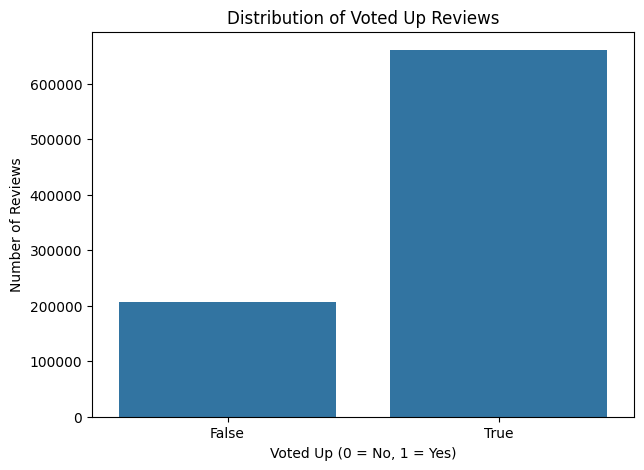

In [ ]:
# Distribution of voted up reviews (reviewer recommends game (yes/no))
plt.figure(figsize=(7,5))
sns.countplot(x='voted_up', data=reviews)
plt.title('Distribution of Voted Up Reviews')
plt.xlabel('Voted Up (0 = No, 1 = Yes)')
plt.ylabel('Number of Reviews')
plt.show()

The bar chart shows that most reviews are marked as “voted up,” meaning the majority of players gave a positive review. Negative reviews are much less common. This imbalance reflects typical behavior on Steam, where satisfied users are more likely to leave feedback than dissatisfied ones.

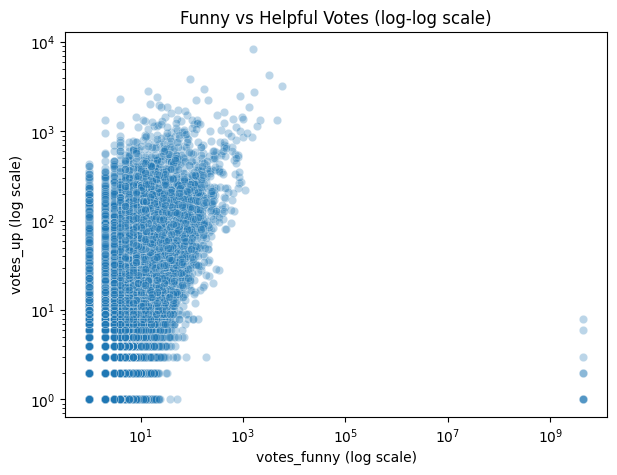

In [ ]:
# Do funny reviews also get helpful votes
# votes_up: how many other users found the review helpful
# votes_funny: how many other users found the review funny
plt.figure(figsize=(7,5))
sns.scatterplot(x="votes_funny", y="votes_up", data=reviews, alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.title("Funny vs Helpful Votes (log-log scale)")
plt.xlabel("votes_funny (log scale)")
plt.ylabel("votes_up (log scale)")
plt.show()

The scatter plot shows that although funnier reviews tend to receive more helpful votes, the relationship is  scattered and noisy. Most reviews receive very low engagement on both metrics, while a few rare viral reviews accumulate extremely high funny counts. This indicates a weak positive relationship between funniness and helpfulness.

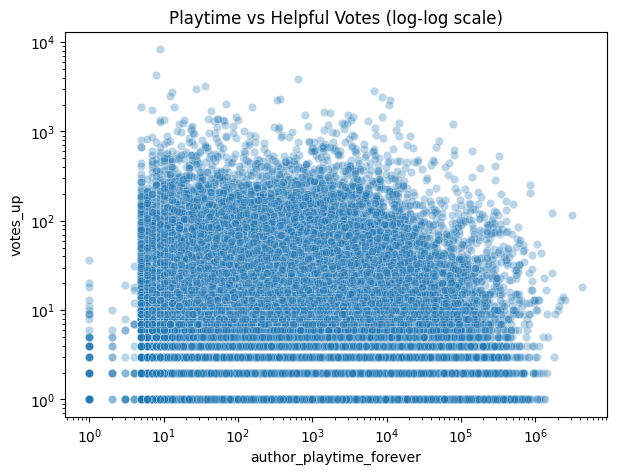

In [ ]:
# Does playtime affect review helpfulness
plt.figure(figsize=(7,5))
sns.scatterplot(x="author_playtime_forever", y="votes_up", data=reviews, alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.title("Playtime vs Helpful Votes (log-log scale)")
plt.show()

The log-log scatter plot shows no strong relationship between playtime and helpful votes. Reviews written by players with very low or very high playtime can both receive anything from zero to thousands of helpful votes. Thus playtime may not be not a strong predictor of review helpfulness.

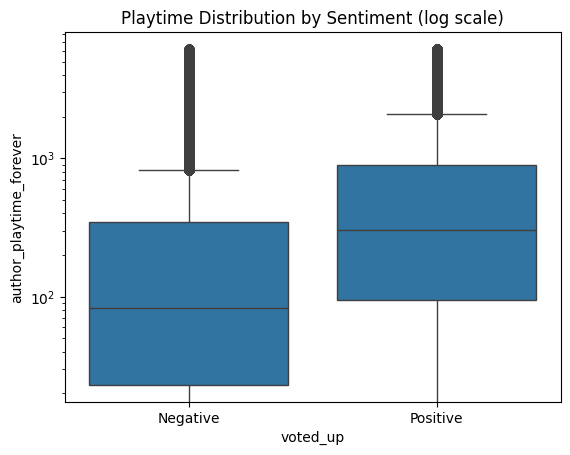

In [ ]:
# Distribution of playtime for positive vs negative review
q = reviews["author_playtime_forever"].quantile(0.95)
df2 = reviews[reviews["author_playtime_forever"] <= q]

sns.boxplot(x="voted_up", y="author_playtime_forever", data=df2)
plt.yscale("log")
plt.xticks([0,1], ["Negative", "Positive"])
plt.title("Playtime Distribution by Sentiment (log scale)")
plt.show()

Positive reviews come from players who generally played the game longer, while negative reviews tend to come from players with lower total playtime. This suggests that enjoyment of the game increases as players spend more time with it, and users who dislike the game tend to abandon it early and give a negative review.

In [ ]:
q = reviews['author_playtime_forever'].quantile(0.95)
outliers = reviews[reviews['author_playtime_forever'] > q]
outliers.describe()

,appid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,timestamp_created,timestamp_updated,votes_up,votes_funny,weighted_vote_score,comment_count
count,4.342400e+04,43424.000000,43424.000000,4.342400e+04,43424.000000,4.342400e+04,4.342400e+04,4.342400e+04,4.342400e+04,43424.000000,4.342400e+04,43424.000000,43424.000000
mean,1.123032e+06,127.645403,29.085275,3.182120e+04,1204.936464,2.203870e+04,1.724986e+09,1.703840e+09,1.705935e+09,4.877326,1.978161e+05,0.525317,0.270818
std,8.790752e+05,539.439168,215.601909,8.205287e+04,2531.141676,5.532142e+04,7.020895e+07,9.545889e+07,9.285337e+07,35.024297,2.914774e+07,0.061503,3.848635
min,4.000000e+02,0.000000,1.000000,6.204000e+03,0.000000,1.000000e+00,8.640000e+04,1.290647e+09,1.290647e+09,0.000000,0.000000e+00,0.007392,0.000000
25%,3.897300e+05,0.000000,2.000000,8.238750e+03,0.000000,5.978750e+03,1.736660e+09,1.699311e+09,1.706542e+09,0.000000,0.000000e+00,0.500000,0.000000
50%,8.929700e+05,0.000000,5.000000,1.237700e+04,8.000000,9.061500e+03,1.755770e+09,1.754918e+09,1.754941e+09,1.000000,0.000000e+00,0.500000,0.000000
75%,1.642610e+06,77.000000,15.000000,2.525325e+04,1270.000000,1.820375e+04,1.756677e+09,1.755855e+09,1.755885e+09,2.000000,0.000000e+00,0.523810,0.000000
max,3.874490e+06,22752.000000,18291.000000,4.309938e+06,20144.000000,2.030768e+06,1.757165e+09,1.757120e+09,1.757120e+09,2844.000000,4.294967e+09,0.975551,666.000000


### 3.1.2 language

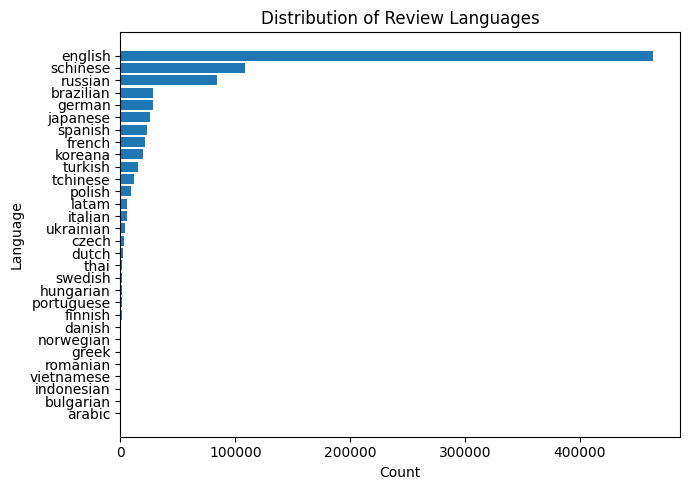

In [ ]:
# Distribution of language
plt.figure(figsize=(7, 5))
plt.barh(reviews["language"].value_counts().index, reviews["language"].value_counts().values)
plt.xlabel("Count")
plt.ylabel("Language")
plt.title("Distribution of Review Languages")
plt.gca().invert_yaxis()   # largest at top
plt.tight_layout()
plt.show()

The distribution of review languages is highly imbalanced, with English dominating the dataset and Simplified Chinese and Russian following. After these three, the counts drop sharply. The majority of remaining languages have fewer than 100,000 reviews, and many fall below 10,000. This long-tail pattern shows that only a some of the languages contribute substantial data. Thus we will later consolidate all languages with fewer than 10,000 reviews into a single category labeled “other” to reduce noise.

### 3.1.3 comment

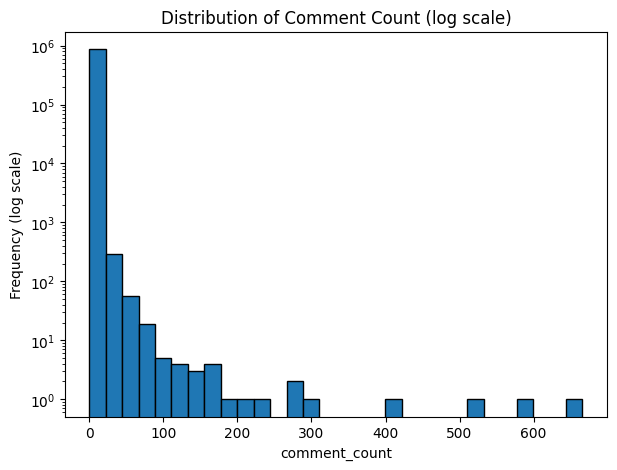

In [ ]:
# Distrtibution of comment count
plt.figure(figsize=(7,5))
plt.hist(reviews['comment_count'], bins=30, edgecolor='black', log=True)
plt.title("Distribution of Comment Count (log scale)")
plt.xlabel("comment_count")
plt.ylabel("Frequency (log scale)")
plt.show()

The distribution of comment counts is right-skewed, with a majority of reviews receiving little to no comments. The tall bar on the left shows that most reviews fall in the 0 - 10 comment range, even when plotted on a log scale. Only a very small number of reviews accumulate hundreds of comments, forming a long tail of highly engaged or controversial posts. Overall, this indicates that meaningful discussion happens on only a tiny fraction of reviews.

### 3.1.4 weighted score

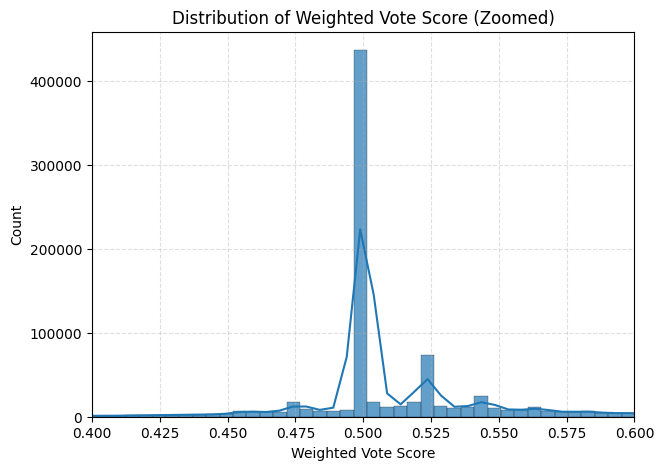

In [ ]:
# Distribution of weighted vote score
plt.figure(figsize=(7,5))
sns.histplot(
    data=reviews,
    x="weighted_vote_score",
    bins=200,
    kde=True,
    alpha=0.7
)

plt.xlim(0.40, 0.60)   # zoom in
plt.xlabel("Weighted Vote Score")
plt.ylabel("Count")
plt.title("Distribution of Weighted Vote Score (Zoomed)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

The weighted_vote_score is a 0 to 1 helpfulness metric, but the histogram shows that almost all reviews cluster tightly around 0.50. This is because Steam applies a Bayesian weighted scoring system that keeps low-vote reviews near a neutral value. Only a small number of reviews accumulate enough helpful votes to push their score significantly higher, resulting in small secondary peaks around 0.52 - 0.55.

## 3.2 Applications-related Features

### 3.2.1 type

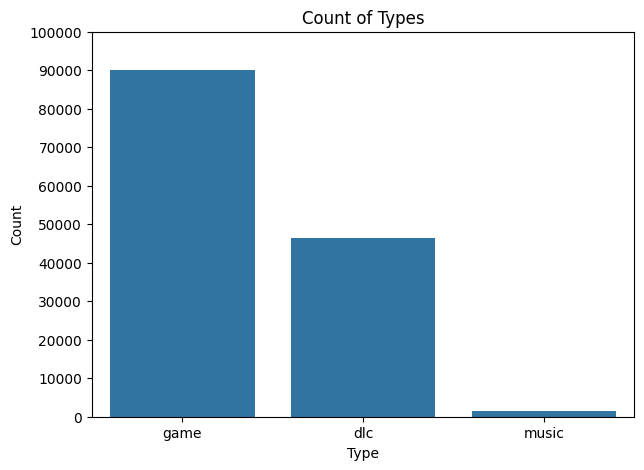

In [ ]:
# Distribution of type
plt.figure(figsize=(7,5))
sns.countplot(data=applications, x="type")
plt.title("Count of Types")
plt.xlabel("Type")
plt.ylabel("Count")
plt.ylim(0, 100001)
plt.yticks(range(0, 100001, 10000))
plt.show()

The majority of Steam applications in our dataset are classified as games, with nearly twice as many entries as DLCs. Music products make up only a very small fraction.

### 3.2.2 currency

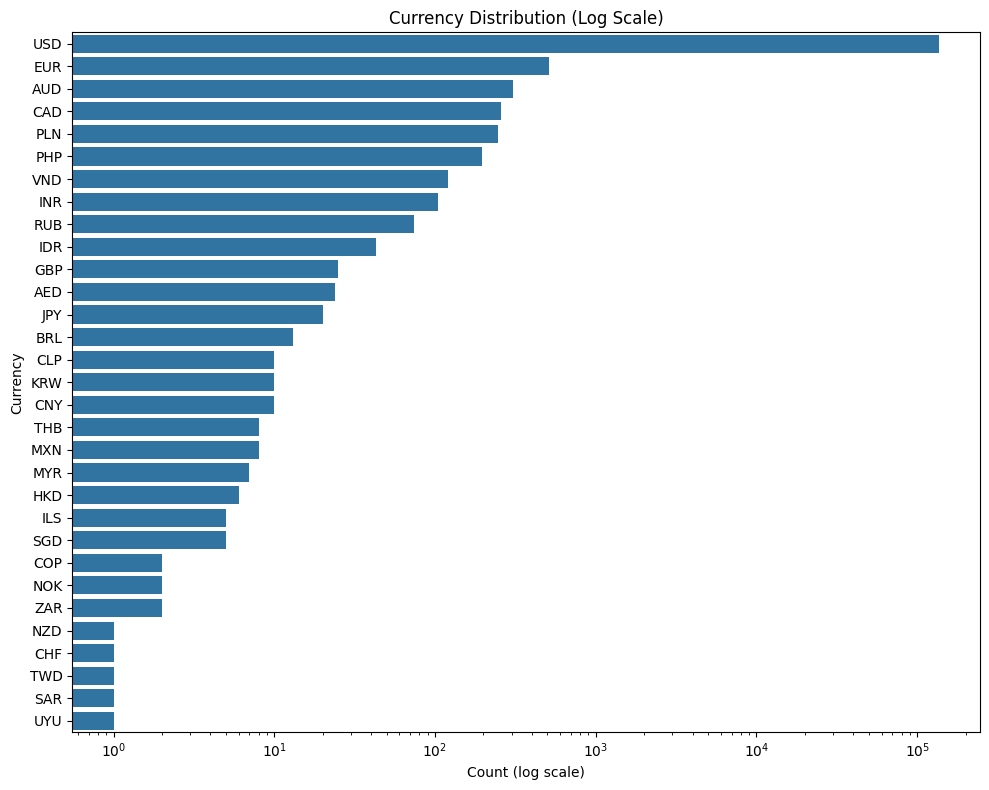

In [ ]:
# Distribution of Currency Count in Log Scale
currency_counts = applications['mat_currency'].value_counts()
plt.figure(figsize=(10,8))
sns.barplot(y=currency_counts.index, x=currency_counts.values)
plt.xscale('log')
plt.title("Currency Distribution (Log Scale)")
plt.xlabel("Count (log scale)")
plt.ylabel("Currency")
plt.tight_layout()
plt.show()

The distribution of the currency is unbalanced as the USD consist of majority of the dataset, with all other currencies appearing at much lower frequencies. So, we would later convert all of the game price into USD to make the computation and interpretation easier.

## 3.3 Genres-related Features

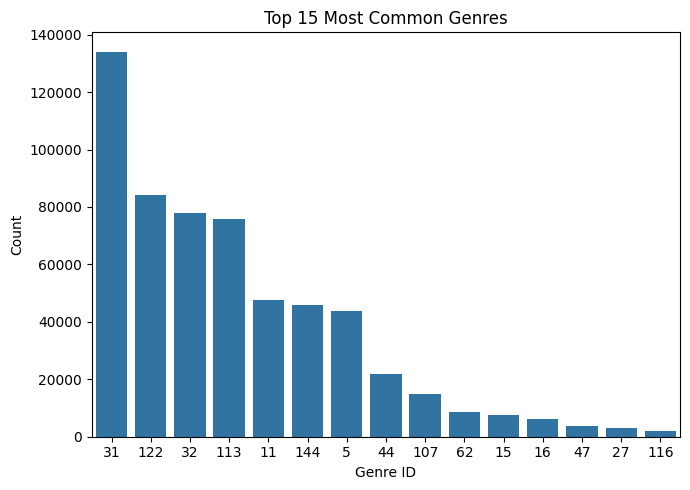

In [ ]:
# Distribution of the top 15 genres
top15_genres = genres["genre_id"].value_counts().sort_values(ascending = False).head(15)
plt.figure(figsize=(7,5))
sns.barplot(x=top15_genres.index.astype(str),y=top15_genres.values)
plt.title("Top 15 Most Common Genres")
plt.xlabel("Genre ID")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

This bar plot shows that a few dominant genres make up a large share of the platform, while many others are represented much less frequently.

## 3.4 Joined data frame EDA

*   Joining the data frames prior to feature engineering to gain insights of raw data



In [ ]:
merged_df_raw = reviews.merge(
    applications,
    on="appid",
    how="inner"
).merge(
    genre_map,
    on="appid",
    how="inner"
)

### 3.4.1 numeric columns correlation

In [ ]:
merged_df_raw.head()

,appid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,language,review_text,timestamp_created,...,is_free,release_date,required_age,supported_languages,mat_supports_windows,mat_supports_mac,mat_supports_linux,mat_initial_price,mat_currency,genre_id
0,264220,760,74,12.0,0.0,12.0,1.399060e+09,polish,What's a crap. This game costs 2 euro but is w...,1399059965,...,False,5/1/2014,0,"English, French, Italian, German, Spanish - Sp...",True,True,True,299.0,USD,"[31, 113, 122]"
1,1006440,485,234,424.0,0.0,424.0,1.632666e+09,russian,ÐÐ³ÑÐ° Ð² Ð¶Ð°Ð½ÑÐµ ÐºÐ²ÐµÑÑÐ° point-&-cl...,1632673992,...,False,1/28/2019,0,English<strong>*</strong><br><strong>*</strong...,True,True,True,699.0,USD,"[5, 113]"
2,1604700,0,3,86.0,0.0,86.0,1.632674e+09,english,"It took me a grueling 18 months, but I built a...",1632675648,...,False,5/3/2021,0,English<strong>*</strong><br><strong>*</strong...,True,True,True,99.0,USD,"[11, 31, 32, 113, 144]"
3,1338560,816,26,25.0,0.0,25.0,1.632639e+09,english,incredibly simple game. it does get boring qui...,1632675819,...,False,6/29/2020,0,"English, French, Italian, German, Spanish - Sp...",True,True,True,199.0,USD,"[5, 11, 31]"
4,1418320,0,1,60.0,0.0,60.0,1.631962e+09,spanish,Un juego entretenido que he regalado a mis sob...,1632675927,...,False,9/16/2021,0,"English<strong>*</strong>, French<strong>*</st...",True,True,True,599.0,USD,"[31, 32, 113]"


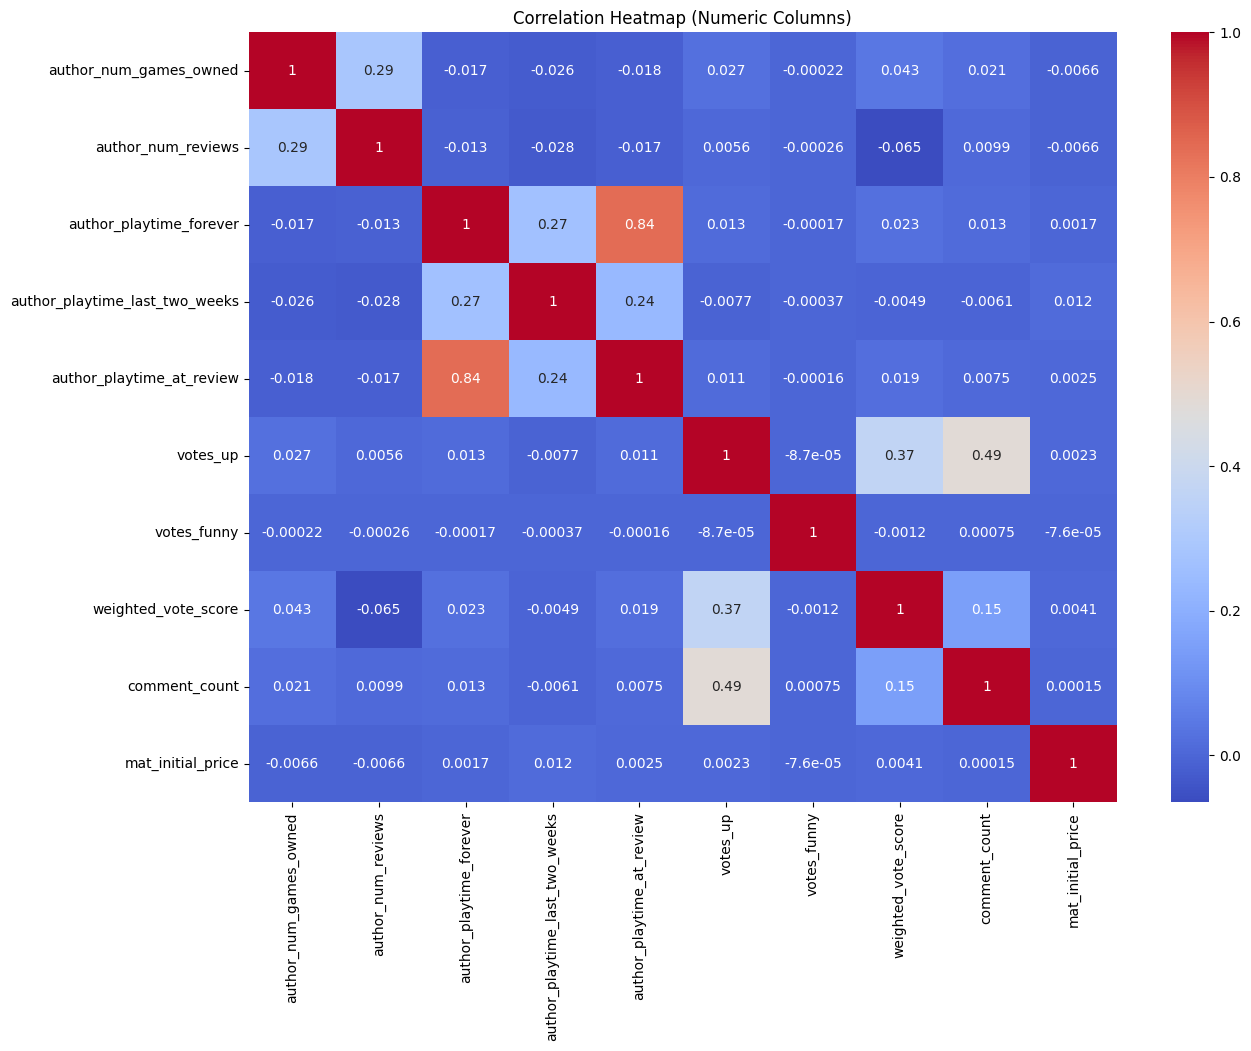

In [ ]:
# Heat map of numerical columns
numeric_cols = [
    'author_num_games_owned', 'author_num_reviews',
    'author_playtime_forever', 'author_playtime_last_two_weeks', 'author_playtime_at_review',
    'votes_up', 'votes_funny',
    'weighted_vote_score', 'comment_count', 'mat_initial_price'
]
plt.figure(figsize=(14,10))
sns.heatmap(merged_df_raw[numeric_cols].corr(), cmap="coolwarm", annot=True)
plt.title("Correlation Heatmap (Numeric Columns)")
plt.show()

The heatmap shows that mat_initial_price does not show meaningful correlation with any of the numerical review or user-behavior features in the dataset. This suggests that variables like playtime, number of games owned, review helpfulness or engagement metrics do not directly explain how a game is priced. If our goal is to predict price, these numeric features alone are likely insufficient. However, they may still become useful when combined with other information. For example through nonlinear models like Random Forests or interactions with genre or release year. The weak correlations highlight the need to incorporate additional features or more complex relationships to successfully predict price.


### 3.4.2 playtime

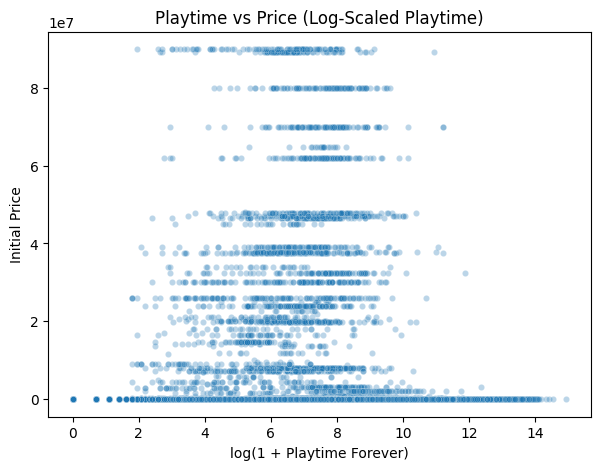

In [ ]:
# Relationship between playtime and price
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=np.log1p(merged_df_raw["author_playtime_forever"]),
    y=merged_df_raw["mat_initial_price"],
    alpha=0.3,
    s=20
)
plt.xlabel("log(1 + Playtime Forever)")
plt.ylabel("Initial Price")
plt.title("Playtime vs Price (Log-Scaled Playtime)")
plt.show()


The scatterplot shows no strong relationship between playtime and game price, even after log-scaling playtime to reduce skew. Games at all price levels are played for widely varying amounts of time, suggesting that how much players play a game does not alone reflect how much it originally costs.

### 3.4.3 comment count

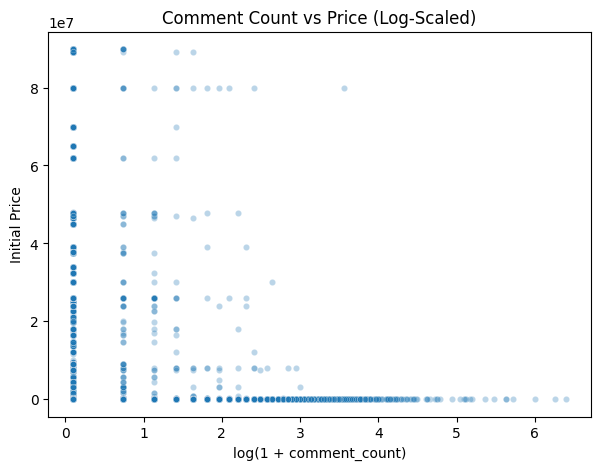

In [ ]:
# Relationship between comment count and price
jitter = 0.1
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=np.log1p(merged_df_raw["comment_count"] + jitter),
    y=merged_df_raw["mat_initial_price"],
    alpha=0.3,
    s=20
)
plt.xlabel("log(1 + comment_count)")
plt.ylabel("Initial Price")
plt.title("Comment Count vs Price (Log-Scaled)")
plt.show()

The scatterplot shows that games across all price levels tend to have very low comment counts, and even when comments increase, prices do not follow any clear trend. The points are widely dispersed and form no visible pattern, suggesting that comment_count does not alone help explain or predict price.

# Part 4: Feature Engineering

## 4.1 reviews.csv

### 4.1.1 Convert Timestamp

In [ ]:
# Convert timestamp to readable time
reviews[['author_last_played','timestamp_created', 'timestamp_updated']] = (
    reviews[['author_last_played', 'timestamp_created', 'timestamp_updated']]
    .apply(pd.to_datetime, unit='s'))

### 4.1.2 Encoding Categorical Features

* Binary encoding boolean columns `voted_up`, `received_for_free`, `written_during_early_access`.
* One hot encoding `language`: keep languages that have over 10,000 rows/reviews and convert other languages with less data to a single category called "other".

In [ ]:
encoded_reviews = reviews.copy()

# Convert voted_up, received_for_free, written_during_early_access: true/false to 0/1
cols_to_convert = ['voted_up', 'received_for_free', 'written_during_early_access']
encoded_reviews = encoded_reviews.dropna(subset=cols_to_convert)
for col in cols_to_convert:
    encoded_reviews[col] = encoded_reviews[col].astype(int)

# Convert language
language_counts = encoded_reviews['language'].value_counts()
major_languages = language_counts[language_counts > 10000].index.tolist()

# Replace rare languages with 'other'
encoded_reviews['language'] = encoded_reviews['language'].apply(
    lambda x: x if x in major_languages else 'other'
)

# One-Hot Encode the language column
ohe = OneHotEncoder(sparse_output=False, drop=None, handle_unknown='ignore')
encoded_array = ohe.fit_transform(encoded_reviews[['language']])
encoded_features = ohe.get_feature_names_out(['language'])
encoded_cat_df = pd.DataFrame(encoded_array, columns=encoded_features, index=encoded_reviews.index)

# Drop original language column and concatenate encoded features
encoded_reviews = pd.concat([encoded_reviews.drop(columns=['language']), encoded_cat_df], axis=1)

* Dropping `review_text`since the textual data would require additional NLP preprocessing and feature extraction, we exclude them to maintain a streamlined modeling pipeline

In [ ]:
# Drop review_text column (not using NLP)
encoded_reviews = encoded_reviews.drop(columns=['review_text'])

### 4.1.3 Handling Time Features

* Extract Year and Month from `timestamp_created`, `author_last_played`, and `timestamp_updated` to create new numerical features which may help with capture pricing trends.

In [ ]:
# Extract and keep year and month of timestamp
encoded_reviews['created_year'] = encoded_reviews['timestamp_created'].dt.year
encoded_reviews['created_month'] = encoded_reviews['timestamp_created'].dt.month
encoded_reviews['last_played_year'] = encoded_reviews['author_last_played'].dt.year
encoded_reviews['last_played_month'] = encoded_reviews['author_last_played'].dt.month
encoded_reviews['updated_year'] = encoded_reviews['timestamp_updated'].dt.year
encoded_reviews['updated_month'] = encoded_reviews['timestamp_updated'].dt.month

# Drop original
encoded_reviews = encoded_reviews.drop(columns=['timestamp_created', 'author_last_played', 'timestamp_updated'])

## 4.2 applications.csv

### 4.2.1 Encoding Categorical Features

* Binary encoding boolean columns `is_free`, `mat_supports_windows`, `mat_supports_mac`, and `mat_supports_linux`.
* One hot encoding `type`.
* Clean non-sensical `supported_languages` entries using regex.
* Create new feature called `num_languages` to capture multilingual support.

In [ ]:
# Convert true/false to 0/1
applications['is_free'] = applications['is_free'].astype(int)
applications['mat_supports_windows'] = applications['mat_supports_windows'].astype(int)
applications['mat_supports_mac'] = applications['mat_supports_mac'].astype(int)
applications['mat_supports_linux'] = applications['mat_supports_linux'].astype(int)

In [ ]:
# One-Hot Encode the type column
encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown='ignore')
type_encoded = encoder.fit_transform(applications[["type"]])
type_df = pd.DataFrame(
    type_encoded,
    columns=encoder.get_feature_names_out(["type"])
)
applications = pd.concat([applications.reset_index(drop=True), type_df], axis=1)

In [ ]:
# Remove any non language terms
def clean_language (text):
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^\x00-\x7F]+", "", text)
    text = re.sub(r"\s*,\s*", ", ", text)
    text = re.sub(r"[^A-Za-z ,\-]", "", text)
    text = re.sub(r"([A-Za-z])languages with full audio support", r"\1, languages with full audio support", text)
    return text

applications['supported_languages'] = applications['supported_languages'].apply(clean_language)

In [ ]:
# Count the number of languages
applications['num_languages'] = applications['supported_languages'].str.count(',') + 1

### 4.2.2 Handling Numerical Features

* Standardize our target variable game price (`mat_initial_price`) to USD for data consistency.
* Drop redundant or unuseful columns.

In [ ]:
# Convert game price to USD
currency_to_usd = {
    "USD": 1.0000, "EUR": 1.1608, "AUD": 0.6528, "CAD": 0.7128, "PLN": 0.2747, "PHP": 0.01694,
    "VND": 0.000060, "INR": 0.011275, "RUB": 0.012352, "IDR": 0.000060, "GBP": 1.3157,
    "AED": 0.2723, "JPY": 0.006469, "BRL": 0.1888, "CLP": 0.001079, "KRW": 0.000687,
    "CNY": 0.140959, "THB": 0.030854, "MXN": 0.054606, "MYR": 0.242109, "HKD": 0.128669,
    "ILS": 0.309969, "SGD": 0.769624, "COP": 0.000266, "NOK": 0.098916, "ZAR": 0.058518,
    "NZD": 0.6025, "CHF": 1.1321, "TWD": 0.0310, "SAR": 0.2667, "UYU": 0.0249
}

applications["mat_initial_price"] = round(applications["mat_initial_price"] * applications["mat_currency"].map(currency_to_usd) / 100, 2)

In [ ]:
# Drop is_free since all rows are 0
applications = applications.drop(columns = ['is_free'])

# Drop imbalanced columns (98% - 2% distribution)
applications = applications.drop(columns = ['required_age', 'mat_supports_windows','mat_supports_mac','mat_supports_linux'])

# Drop supported_languages & mat_currency columns since unused for price
applications = applications.drop(columns = ['supported_languages', 'mat_currency'])

### 4.2.3 Handling Time Features

* Extract Year and Month from `release_date` to create two new numerical features `release_year` and `release_month` which may help with capture pricing trends over time.
* Rename target variable column to `price` for clarity.

In [ ]:
# Transform release_date
applications['release_date'] = pd.to_datetime(applications['release_date'])
applications['release_year'] = applications['release_date'].dt.year
applications['release_month'] = applications['release_date'].dt.month
applications = applications.drop(columns = ['release_date'])

In [ ]:
# Rename columns for better interpretation
applications = applications.rename(columns={'mat_initial_price': 'price'})

In [ ]:
applications.head()

,appid,name,type,price,type_dlc,type_game,type_music,num_languages,release_year,release_month
0,10,Counter-Strike,game,9.99,0.0,1.0,0.0,9,2000,11
1,20,Team Fortress Classic,game,4.99,0.0,1.0,0.0,9,1999,4
2,30,Day of Defeat,game,4.99,0.0,1.0,0.0,5,2003,5
3,40,Deathmatch Classic,game,4.99,0.0,1.0,0.0,9,2001,6
4,50,Half-Life: Opposing Force,game,4.99,0.0,1.0,0.0,4,1999,11


## 4.3 Joining Data Frames

For this step, we joined feature engineered `encoded_reviews`, `applications`, and `genre_map` using the primary and foreign key relationship to obtain our main data frame `merged_df`. `merged_df` have 798,556 rows in total.

In [ ]:
merged_df = encoded_reviews.merge(
    applications,
    on="appid",
    how="inner"
).merge(
    genre_map,
    on="appid",
    how="inner"
)

In [ ]:
merged_df.shape

(798556, 41)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798556 entries, 0 to 798555
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   appid                           798556 non-null  int64  
 1   author_num_games_owned          798556 non-null  int64  
 2   author_num_reviews              798556 non-null  int64  
 3   author_playtime_forever         798556 non-null  float64
 4   author_playtime_last_two_weeks  798556 non-null  float64
 5   author_playtime_at_review       798556 non-null  float64
 6   voted_up                        798556 non-null  int64  
 7   votes_up                        798556 non-null  int64  
 8   votes_funny                     798556 non-null  int64  
 9   weighted_vote_score             798556 non-null  float64
 10  comment_count                   798556 non-null  int64  
 11  received_for_free               798556 non-null  int64  
 12  written_during_e

For further feature engineering, we converted the list of genres for each game into multiple one-hot encoded columns.

In [ ]:
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(merged_df['genre_id'])
genre_df = pd.DataFrame(
    genre_matrix,
    index=merged_df.index,
    columns=[f"genre_{g}" for g in mlb.classes_]
)
merged_df = merged_df.drop(columns=['genre_id'])
merged_df = pd.concat([merged_df, genre_df], axis=1)

In [ ]:
merged_df.shape

(798556, 76)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798556 entries, 0 to 798555
Data columns (total 76 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   appid                           798556 non-null  int64  
 1   author_num_games_owned          798556 non-null  int64  
 2   author_num_reviews              798556 non-null  int64  
 3   author_playtime_forever         798556 non-null  float64
 4   author_playtime_last_two_weeks  798556 non-null  float64
 5   author_playtime_at_review       798556 non-null  float64
 6   voted_up                        798556 non-null  int64  
 7   votes_up                        798556 non-null  int64  
 8   votes_funny                     798556 non-null  int64  
 9   weighted_vote_score             798556 non-null  float64
 10  comment_count                   798556 non-null  int64  
 11  received_for_free               798556 non-null  int64  
 12  written_during_e

In [ ]:
merged_df.head()

,appid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,voted_up,votes_up,votes_funny,weighted_vote_score,...,genre_113,genre_116,genre_122,genre_123,genre_130,genre_131,genre_134,genre_139,genre_144,genre_151
0,264220,760,74,12.0,0.0,12.0,1,0,1,0.459906,...,1,0,1,0,0,0,0,0,0,0
1,1006440,485,234,424.0,0.0,424.0,1,8,0,0.630770,...,1,0,0,0,0,0,0,0,0,0
2,1604700,0,3,86.0,0.0,86.0,1,3,0,0.541985,...,1,0,0,0,0,0,0,0,1,0
3,1338560,816,26,25.0,0.0,25.0,1,1,0,0.523810,...,0,0,0,0,0,0,0,0,0,0
4,1418320,0,1,60.0,0.0,60.0,1,2,0,0.545455,...,1,0,0,0,0,0,0,0,0,0


## 4.4 Create Training and Testing Data

Since our models require training and testing dataset, we chose 80/20 train-test split since this is a common ratio to maintain a balance of training and testing in machine learning.

In [ ]:
# Conduct 80/20 train-test split with random_state = seed = 42
merged_copy = merged_df.copy()

X = merged_copy.drop(columns=["price"])
y = merged_copy["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 4.5 PCA

We applied **Principal Component Analysis (PCA)** to improve model efficiency and performance when working with a large feature space. The dataset contains over 70 numerical and one-hot encoded features. Reducing data dimentionality can be helpful for avoiding feature redundacy that could increases noise and multicollinerity. Data is reduced to a smaller number of principal components that retain most of the variance while removing less informative dimensions.

**Scaling**: Before applying PCA, features are standardized using StandardScaler. This preprocessing step is important because PCA is sensitive to feature scaling.

In [ ]:
non_numeric_cols = ['appid', 'name', 'type']
X_train_num = X_train.drop(columns=non_numeric_cols)
X_test_num = X_test.drop(columns=non_numeric_cols)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

 **Choosing PCA Components**: To determine an appropriate number of principal components for dimensionality reduction, we used the cumulative explained variance against the number of components, as shown in the figure below. The red horizontal line indicates the 80% variance threshold, which is a common threshold to retain most of the essential information in the dataset while reducing noise and redundancy. From the curve, we observed that the explained variance begins to level off around 40 to 50 components. Based on this observation, we selected 45 as the number of principal components that preserve around 80% of the total variance.

In [ ]:
explained_variance_ratios = pca.explained_variance_ratio_

cum_evr = np.cumsum(explained_variance_ratios)

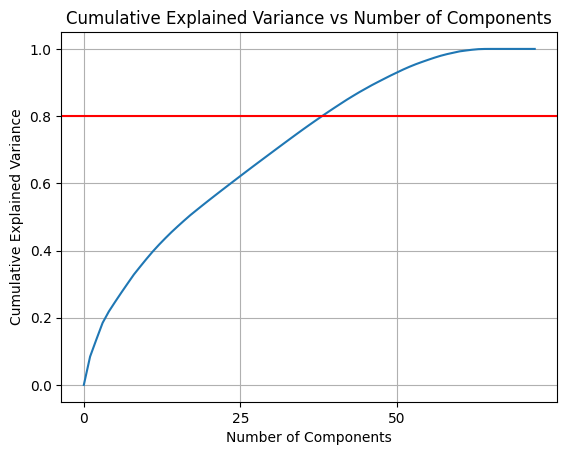

In [ ]:
cum_evr = np.insert(cum_evr, 0, 0) # dummy variable so number of components starts at 1
plt.plot(cum_evr)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.axhline(y = 0.8, color = 'r', linestyle = '-')
plt.xticks(np.arange(0, len(explained_variance_ratios)+1, 25))
plt.grid()
plt.show()

In [ ]:
X_test_scaled = scaler.transform(X_test_num)
pca_final = PCA(n_components = 45)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

### 4.6 Final Feature Set

After completing data preprocessing and feature engineering, we finalized three different versions of the input features to support model training and performance comparison:

* `X_train_scaled`, X_test_scaled`: scaled numeric features which standardized inputs for models that are sensitive to feature scaling and variance.
* `X_train_pca`, `X_test_pca`: PCA-reduced features which are dimensionality-reduced representations (45 principal components).
* `X_train_num`, `X_test_num`: raw numeric features

# Part 5: Exploratory Data Analysis Pt.2

We decided to add an extra EDA to better visualize and help us understand the features distribution after feature engineering for better model training.

### 5.1.1 Price

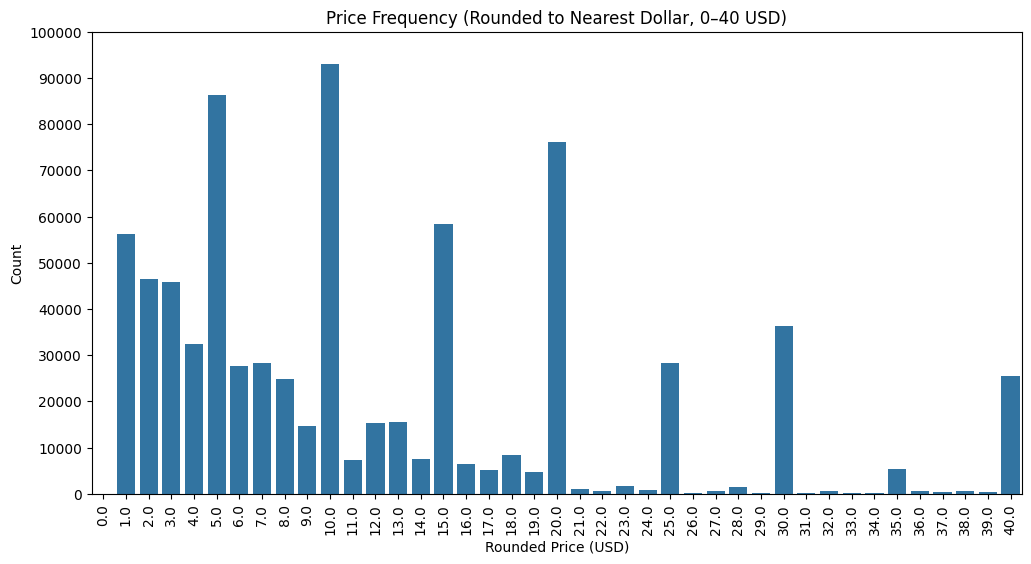

In [ ]:
# Distribution of Price(rounded to nearest dollar between 0 and 40)
merged_df_copy = merged_df.copy()
merged_df_copy["price_rounded"] = merged_df_copy["price"].round()
price_counts_round = merged_df_copy["price_rounded"].value_counts().sort_index().loc[0:40]

plt.figure(figsize=(12,6))
sns.barplot(x=price_counts_round.index, y=price_counts_round.values)
plt.title("Price Frequency (Rounded to Nearest Dollar, 0–40 USD)")
plt.xlabel("Rounded Price (USD)")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.ylim(0, 100000)
plt.yticks(range(0, 100001, 10000))
plt.show()

The price distribution is heavily concentrated at low price points, common pricing tiers like 1 - 5 dollars showing the highest frequencies. A noticeable spike also appears at 10 dollars, reflecting another popular pricing threshold. Beyond 15 dollars, the number of games drops sharply, showing that most Steam titles are priced under 20 dollars.

### 5.1.2 Language

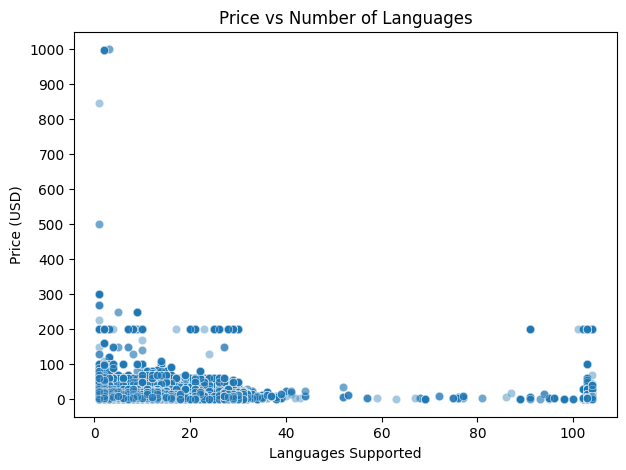

In [ ]:
# Number of languages and price distribution
plt.figure(figsize=(7,5))
sns.scatterplot(data=merged_df_copy, x="num_languages", y="price", alpha=0.4)
plt.title("Price vs Number of Languages")
plt.xlabel("Languages Supported")
plt.ylabel("Price (USD)")
plt.yticks(range(0, 1001, 100))
plt.show()

This scatter plot shows no strong relationship between price and the number of supported languages. Most games, regardless of how many languages they offer, are priced under $100. Only a few outliers reach very high prices. Thus increasing number of language supported does not appear to be associated with pricing decisions.

### 5.1.3 release year

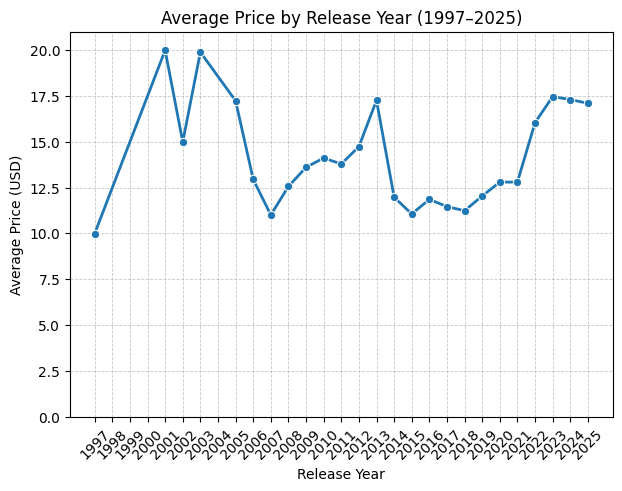

In [ ]:
# Average Price by Release Year
avg_price_year = merged_df_copy.groupby("release_year")["price"].mean()
avg_price_year = avg_price_year.reindex(pd.Index(range(1995, 2026)))
plt.figure(figsize=(7,5))
sns.lineplot(x=avg_price_year.index,y=avg_price_year.values,marker='o',markersize=6,linewidth=2,)
plt.title("Average Price by Release Year (1997–2025)")
plt.xlabel("Release Year")
plt.ylabel("Average Price (USD)")
plt.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
plt.xticks(range(1997, 2026, 1), rotation=45)
plt.ylim(0, 21)
plt.show()

The average game price fluctuates over time rather than showing a clear upward or downward trend. Overall, the relationship between release year and game price is weak, and no strong linear trend can be concluded.

# Part 6: Modeling: Baseline

## 6.1 Linear Regression

First we try the standard Linear regression model trained on scaled features:
*   use StandardScaler to normalize all numeric features
*   use ordinary least squares to find the best-fitting linear combination of features that predicts game prices
*   evaluate performance using MAE, RMSE, and R² on the test set

We chose Linear Regression as our simplest baseline because:
* it uses only linear relationships between features and price
* this helps establish a reference level of performance, which anything more complex should outperform this model


In [ ]:
# Train model on scaled-only data (No PCA)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

MAE: 8.489658730570156
RMSE: 14.986755459120596
R2: 0.24553498709540222


In [ ]:
# Train model on PCA-transformed data
lr = LinearRegression()
lr.fit(X_train_pca, y_train)

y_pred = lr.predict(X_test_pca)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

MAE: 8.514911846167994
RMSE: 15.11903548733126
R2: 0.23215769581937584


## 6.2 CatBoost

Next, we try the CatBoost Gradient Boosting model:
*   use CatBoost’s built-in handling of categorical variables to automatically encode the type feature
*   train an ensemble of decision trees using gradient boosting
*   apply early stopping
*   evaluate performance using MAE, RMSE, and R² on the test set

Since with EDA we found that the numerical features do not show significant relation with the price, we decided to focus on tree-based models.
We chose CatBoost Regressor because:
* our dataset contains many categorical variables, and CatBoost is designed to handle these features without manual encoding
* it also captures non-linear patterns

In [ ]:
train_pool = Pool(X_train_scaled, label=y_train)
valid_pool = Pool(X_test_scaled,  label=y_test)

model = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    depth=6,
    learning_rate=0.1,
    iterations=1000,
    random_seed=42,
    l2_leaf_reg=3,
    od_type="Iter",
    od_wait=30,
    verbose=200,
    task_type="GPU"
)

model.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True
)

y_pred = model.predict(valid_pool)

# Metrics
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")

0:	learn: 16.3751691	test: 16.6098268	best: 16.6098268 (0)	total: 302ms	remaining: 5m 1s
200:	learn: 10.0874925	test: 11.0179489	best: 11.0179489 (200)	total: 1.82s	remaining: 7.25s
400:	learn: 9.4148143	test: 10.4773874	best: 10.4773874 (400)	total: 3.24s	remaining: 4.84s
600:	learn: 9.0137789	test: 10.1732971	best: 10.1732971 (600)	total: 4.64s	remaining: 3.08s
800:	learn: 8.7417539	test: 10.0041344	best: 10.0036672 (799)	total: 6.03s	remaining: 1.5s
999:	learn: 8.5208310	test: 9.8548348	best: 9.8547055 (998)	total: 8.16s	remaining: 0us
bestTest = 9.85470547
bestIteration = 998
Shrink model to first 999 iterations.
MAE : 5.595
RMSE: 9.855
R²  : 0.674


## 6.3 Random Forest

Lastly we try the Random Forest regression model:
* use a RandomForestRegressor to build  decision trees and averages their predictions
* train the model using 150 trees
* evaluate performance using MAE, RMSE, and R² on the test set

We chose Random Forest because:
*  it is a robust model that captures complex interactions between features
* by averaging many decision trees, it is an ideal baseline for evaluating more advanced models


In [ ]:
rf = RandomForestRegressor(
    n_estimators=150,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=3,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")

MAE : 3.306
RMSE: 7.926
R²  : 0.789


**Linear Regression:** We evaluated a baseline Linear Regression model using PCA-transformed features (45 principal components) and scaled-only features. This approach was intended to reduce multicollinearity and noise in the data, however, performance remained weak. The model achieved an $R^2$ of 0.232 which is even lower than the result of using scaled-only feature set. These results indicate that game pricing behavior is not well captured by a simple linear model and that dimensionality reduction removes important predictive signals.

**CatBoost:** Next, we trained a CatBoost model using the scaled feature set. Performance improved substantially compared to Linear Regression, achieving an $R^2$ of 0.674. This demonstrates that boosting-based tree models can capture more representation of pricing behavior.

**Random Forest:** We further evaluated a Random Forest model on the same non-PCA scaled features. Random Forest has the best baseline performance, with an $R^2$ of 0.789. The results highlight the importance of maintaining full feature dimensionality.

These baseline results provide two key insights:
1. Tree-based ensemble methods significantly outperform linear modeling approaches.
2. PCA is not beneficial for models designed to learn nonlinear relationships.

Based on these findings, our next step focuses on improving ensemble performance through hyperparameter tuning of **CatBoost** and **Random Forest**, and introducing **XGBoost**, using the scaled feature set without PCA.

# Part 7: Modeling Pt. 2: Hyperparameter Tuning

PCA reduces dimensionality by transforming features into new orthogonal components, which can be useful for linear models but is generally harmful for tree-based methods like CatBoost. CatBoost relies on finding meaningful splits in the original feature space. PCA makes splits less interpretable and can reduce the model’s ability to capture natural patterns in the data. In addition, CatBoost already includes built-in mechanisms for handling high-dimensional data, categorical variables, and multicollinearity. Because PCA provides little to no performance benefit for gradient boosting decision trees, it is typically better to train CatBoost directly on the original features.

## 7.1 CatBoost (No PCA)

In [ ]:
# Create CatBoost Pool objects for training and testing
X_train = X_train.drop(columns=['name'])
X_test = X_test.drop(columns=['name'])
train_pool = Pool(X_train, y_train, cat_features=['type'])
test_pool  = Pool(X_test, y_test,  cat_features=['type'])

# Baseline CatBoost model configuration
baseline_parameters = {
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "depth": 6,
    "learning_rate": 0.1,
    "iterations": 1000,
    "random_seed": 42,
    "l2_leaf_reg": 3,
    "od_type": "Iter",
    "od_wait": 30,
    "verbose": 200,
    "task_type": "GPU"
}

model = CatBoostRegressor(
    **baseline_parameters
)

# Define hyperparameters for the Grid Search
param_grid = {
    "depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1, 0.2, 0.5],
    "l2_leaf_reg": [3, 5],
}

# Perform Grid Search
grid_result = model.grid_search(
    param_grid,
    X=train_pool,
    verbose=True
)

best_params = model.get_params()
print("Best parameters:", best_params)

0:	learn: 21.4620549	test: 22.0649129	best: 22.0649129 (0)	total: 59.4ms	remaining: 59.4s
200:	learn: 10.1294615	test: 10.5356214	best: 10.5355984 (197)	total: 8.99s	remaining: 35.8s
400:	learn: 9.6406260	test: 9.9706858	best: 9.9706858 (400)	total: 14.6s	remaining: 21.8s
600:	learn: 9.3214026	test: 9.5505994	best: 9.5501335 (599)	total: 21.8s	remaining: 14.5s
800:	learn: 9.1382893	test: 9.3283444	best: 9.3283444 (800)	total: 32.8s	remaining: 8.15s
999:	learn: 9.0810367	test: 9.2614270	best: 9.2614270 (999)	total: 39.1s	remaining: 0us
bestTest = 9.261426979
bestIteration = 999
0:	loss: 9.2614270	best: 9.2614270 (0)	total: 41.8s	remaining: 16m 2s
0:	learn: 20.8526623	test: 21.4704183	best: 21.4704183 (0)	total: 58.6ms	remaining: 58.6s
200:	learn: 9.6493854	test: 10.0766471	best: 10.0735028 (198)	total: 13.7s	remaining: 54.3s
400:	learn: 9.2211009	test: 9.6044821	best: 9.6037365 (398)	total: 21.2s	remaining: 31.6s
600:	learn: 9.0737178	test: 9.4413121	best: 9.4407090 (596)	total: 27s	rem

* depth: maximum depth of each decision tree. Deeper trees allow the model to learn more complex patterns but increase the risk of overfitting.

* learning_rate: Determines learning rate of how much each new tree contributes to the model. Smaller values make training more stable but require more boosting iterations, while larger values speed up learning but may overshoot optimal solutions.

* l2_leaf_reg: L2 regularization applied to leaf weights. Higher values strengthen regularization, reducing variance and helping prevent overfitting, while lower values allow the model to fit the data more closely.

We applied hyperparameter tuning to a CatBoost Regressor using the grid_search method. Because CatBoost handles categorical variables natively, we provided the "name" and "type" feature as a categorical column using the Pool structure for both training and testing sets. We first defined a set of training parameters that is the same as the baseline model. A parameter grid was then specified to explore alternative values for depth, learning rate, and L2 regularization. CatBoost’s grid search evaluated each parameter combination using internal cross-validation. After the search completed, the best-performing parameter configuration was used to fit the final model. Model performance was then measured on the test set using MAE, RMSE, and R² to assess predictive accuracy.

In [ ]:
# Record the hyperparameters based on the grid search above
best_catboost_model = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    depth=8,
    learning_rate=0.5,
    iterations=1000,
    random_seed=42,
    l2_leaf_reg=5,
    od_type="Iter",
    od_wait=30,
    verbose=200,
    task_type="GPU"
)

best_catboost_model.fit(train_pool, eval_set = test_pool)

# Predict on test set
y_pred = best_catboost_model.predict(test_pool)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2:   {r2:.4f}")

0:	learn: 13.7709981	test: 14.1750588	best: 14.1750588 (0)	total: 118ms	remaining: 1m 57s
200:	learn: 7.1687859	test: 8.1154204	best: 8.1154204 (200)	total: 13s	remaining: 51.8s
400:	learn: 6.1652669	test: 7.3861093	best: 7.3861093 (400)	total: 21s	remaining: 31.3s
600:	learn: 5.5515431	test: 6.9681044	best: 6.9618966 (597)	total: 27.6s	remaining: 18.3s
800:	learn: 5.1244076	test: 6.7019584	best: 6.7019584 (800)	total: 35.7s	remaining: 8.88s
999:	learn: 4.8310431	test: 6.5427305	best: 6.5427305 (999)	total: 42.3s	remaining: 0us
bestTest = 6.542730464
bestIteration = 999
MAE:  3.5939
RMSE: 6.5427
R2:   0.8562


Before tuning:
* MAE : 5.595
* RMSE: 9.855
* R²  : 0.674


After tuning:
* MAE:  3.5939
* RMSE: 6.5427
* R²:   0.8562

After tuning the CatBoost model, performance improved substantially across all evaluation metrics, indicating stronger predictive accuracy and better handling of complex feature interactions. The MAE decreased by 3 from 5.595, showing that the tuned model produces far smaller average errors when estimating game prices. Similarly, the RMSE dropped around 3.5 from 9.855, reflecting fewer large deviations and a more stable prediction distribution. Most notably, the R² score increased from 0.674 to above 0.85, meaning the tuned CatBoost model explains a much larger portion of the variance in game prices. These improvements demonstrate that hyperparameter optimization enabled CatBoost to generalize more effectively and deliver significantly more reliable price predictions.

### 7.1.1 Exploring Feature Importance

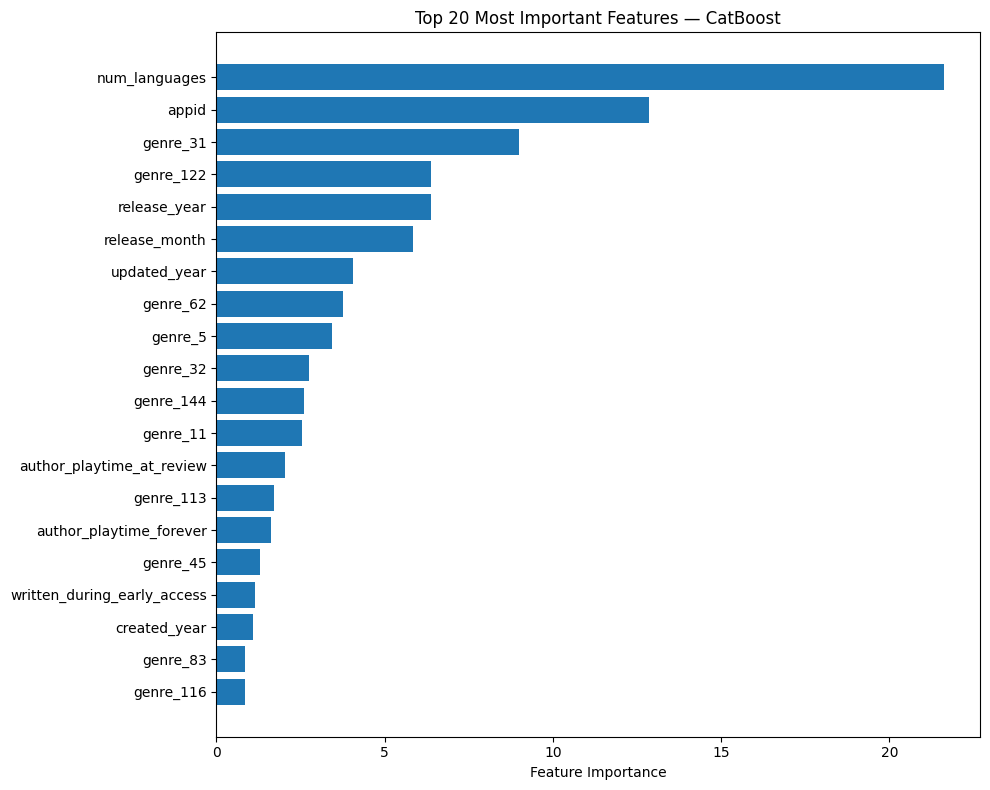

In [ ]:
feature_names = X_train.columns

# Get CatBoost feature importances
importances = best_catboost_model.get_feature_importance(train_pool)

# Create a DataFrame for sorting and plotting
feat_imp = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

# Plot top 20 most important features
top_k = 20
plt.figure(figsize=(10, 8))
plt.barh(feat_imp["feature"][:top_k], feat_imp["importance"][:top_k])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features — CatBoost")
plt.tight_layout()
plt.show()

The above graph indicates that num_languages is the strongest predictor of game price, followed by key genre-related features such as genre_31 and genre_122. Release characteristics (release_year, release_month, and updated_year) also contribute significantly. Overall, the model relies most heavily on language availability, game identity, and temporal and genre attributes to predict pricing.

## 7.2 Random Forest (No PCA)

PCA transforms the data by rotating it into new axes that maximize variance. While this is useful for linear models, it often destroys the natural structure that tree-based models rely on. Random Forests excel when features have meaningful, interpretable splits. Yet PCA mixes all original features into abstract components, which can make decision boundaries more complex. As a result, PCA rarely improves Random Forest performance and can actually increase processing time because the transformed features are harder for trees to split on. In most cases, Random Forests perform better and run faster when trained directly on the original features.

In [ ]:
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Remove string columns
X_train_num = X_train.drop(columns=["name", "type"])
X_test_num  = X_test.drop(columns=["name", "type"])

# Sample 100k rows for faster tuning
sample_idx = np.random.choice(X_train_num.index, 100000, replace=False)
X_small = X_train_num.loc[sample_idx]
y_small = y_train.loc[sample_idx]

rf = RandomForestRegressor(n_jobs=-1, random_state=42)

param_dist = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [8, 10, 12, 15, None],
    "max_features": ["sqrt", "log2", 0.3, 0.5, None],
    "min_samples_split": [2, 5, 10, 20, 50],
    "min_samples_leaf": [1, 3, 5, 10, 20]
}

# Use Randomized Search
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,           # testing 20 different hyperparameter combinations
    cv=3,                # 3-fold cross-validation
    n_jobs=-1,
    random_state=42,
    verbose=2
)

search.fit(X_small, y_small)

print("Best parameters:", search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.5, 'max_depth': None}


Hyperparameter tuning using Randomized Search:
*   n_estimators: number of trees in the forest
*   max_depth: maximum depth of each tree
*   max_features: number of features to consider at each split
*   min_samples_split: minimum samples required to split an internal node
*   min_samples_leaf: minimum samples required in each leaf node

We performed hyperparameter tuning on a Random Forest Regressor using RandomizedSearchCV. Because the dataset is large, we first sampled 100,000 points for optimization efficiency while preserving data diversity. We defined search ranges for key Random Forest parameters stated above. RandomizedSearch tested 20 randomly selected hyperparameter combinations using 3-fold cross-validation, resulting in Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.5, 'max_depth': None}

In [ ]:
best_params = {
    'n_estimators': 50,
    'min_samples_split': 5,
    'min_samples_leaf': 3,
    'max_features': 0.5,
    'max_depth': None
}

# Build model using best params
best_rf = RandomForestRegressor(
    **best_params,
    n_jobs=-1,
    random_state=42
)

best_rf.fit(X_train_num, y_train)
y_pred = best_rf.predict(X_test_num)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")

MAE : 2.269
RMSE: 6.845
R²  : 0.843


### 7.2.1 Exploring Feature Importance

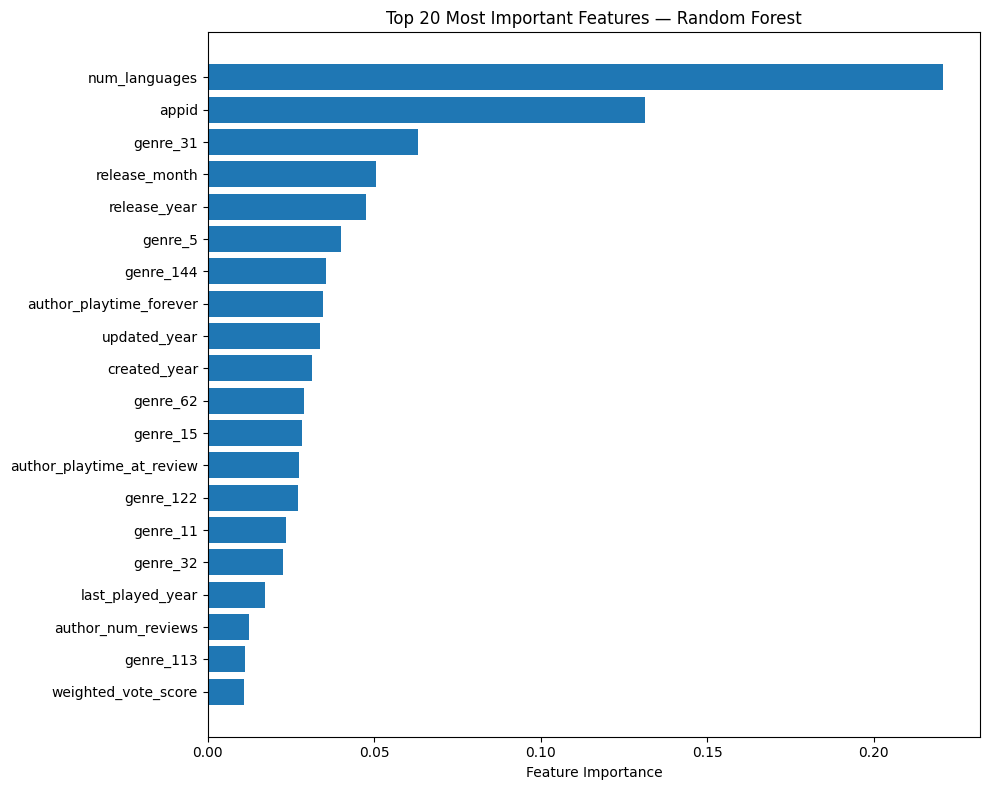

In [ ]:
feature_names = X_train_num.columns

importances = best_rf.feature_importances_

feat_imp = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)


top_k = 20
plt.figure(figsize=(10, 8))
plt.barh(feat_imp["feature"][:top_k], feat_imp["importance"][:top_k])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features — Random Forest")
plt.tight_layout()
plt.show()

This visualization shows that product-level attributes, especially the number of supported languages and specific genre indicators, are the strongest predictors of price. Temporal features such as release month/year and update history also play a meaningful role, while user-activity variables contribute less. This suggests that product characteristics and lifecycle timing drive price more than user engagement metrics.

Before tuning:
*   MAE : 3.306
*   RMSE: 7.927
*   R²  : 0.789

After tuning:
*   MAE:  2.269
*   RMSE: 6.845
*   R²: 0.843

After tuning the Random Forest hyperparameters, the model showed consistent improvements across all evaluation metrics, indicating more accurate predictions and fewer large errors. The R² score also increased from 0.789 to 0.843, meaning the tuned model explains a larger proportion of the variance in game prices. Although the RMSE remains higher than the MAE due to a small number of outlier titles with large price deviations, the tuned model clearly generalizes better and captures underlying pricing patterns more effectively.

## 7.3 XGBoost (No PCA)

We introduced XGBoost to our modeling process because it is one of the most powerful gradient boosting algorithms. Unlike simpler ensemble methods, XGBoost introduces advanced regularization mechanisms, weighted tree growth, and learning-rate-based convergence, allowing it to capture complex nonlinear relationships that can affect pricing. Additionally, XGBoost is suitable for handling large dataset as it is engineered for computational efficiency. Given these, XGBoost is an appropriate choice for improving our baseline models.

In [ ]:
xgb_model = XGBRegressor(
    n_estimators=400,      # more trees improves results for big data
    max_depth=8,           # prevents overfitting too deep
    learning_rate=0.05,    # small steps usually better
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    tree_method='hist',    # fast for large datasets
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test_scaled)

# Evaluate
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")


### 7.3.1 Hyperparameter tuning

To improve XGBoost performance, we conducted hyperparameter tuning using **RandomizedSearchCV** over a comprehensive search space. This process identified the best hyperparameters, including the optimal number of boosting trees (`n_estimators`), tree depth (`max_depth`), learning rate, subsampling ratios (`subsample`, `colsample_bytree`), child node constraints (`min_child_weight`), and split regularization (`gamma`). We explored combinations of these parameters using 3-fold cross-validation.

In [ ]:
param_grid = {
    'n_estimators': [300, 400, 600, 800],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.03, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

xgb = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42
)

search.fit(X_train_scaled, y_train)
print("Best Params:", search.best_params_)
print("Best R2 Score:", search.best_score_)

In [ ]:
# Train using the best parameters
# best_xgb = search.best_estimator_
best_xgb = XGBRegressor(
    n_estimators=800,
    min_child_weight=5,
    max_depth=10,
    learning_rate=0.1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)

best_xgb.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = best_xgb.predict(X_test_scaled)

# Evaluate
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")

MAE : 3.818
RMSE: 7.447
R²  : 0.814


Before tuning:
*   MAE : 5.108
*   RMSE: 9.008
*   R²  : 0.727

After tuning:
*   MAE: 3.818
*   RMSE: 7.447
*   R²: 0.814

After applying hyperparameter optimization, performance improved significantly across all evaluation metrics. The tuned model reached an $R^2$ of 0.814, reflecting a stronger fit to the data. The MAE and RMSE decreased to 3.818 and 7.447, showing a meaningful reduction in both average and large prediction errors.

XGBoost achieved strong performance because its boosted decision tree structure can capture complex, nonlinear patterns in the data. It also uses regularization to avoid overfitting and automatically learns which features are most important.

### 7.3.2 Exploring Feature Importance

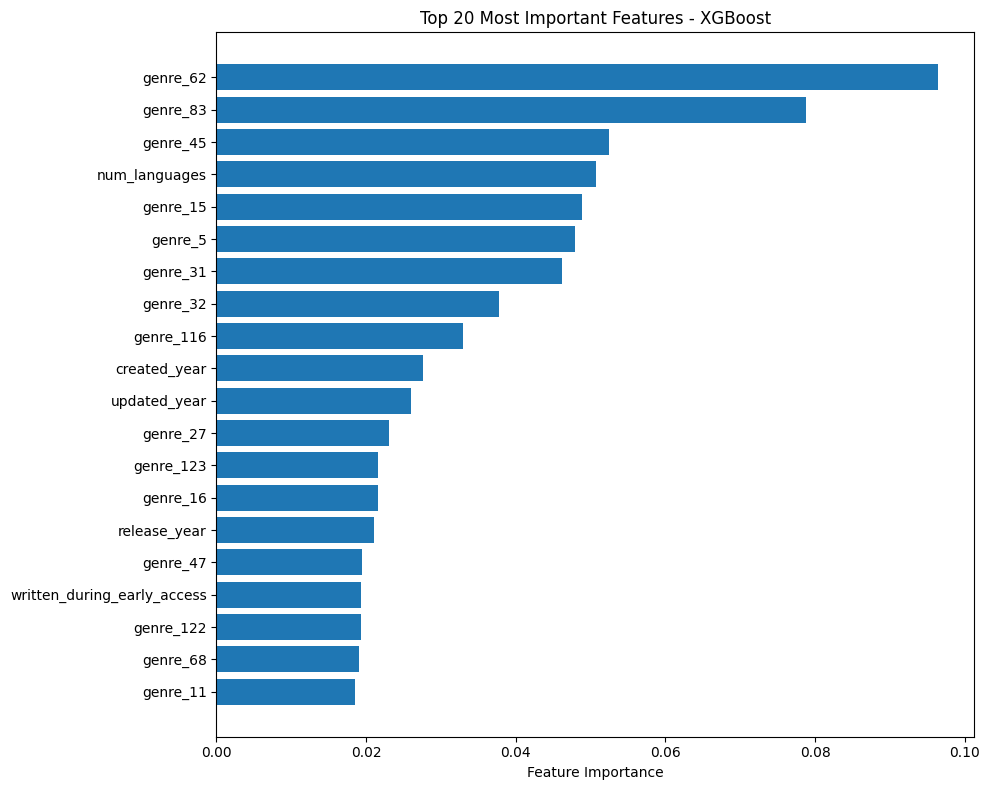

In [ ]:
non_numeric_cols_for_xgb = ['appid', 'name', 'type']
feature_names = X_train.drop(columns=non_numeric_cols_for_xgb, errors='ignore').columns

importances = best_xgb.feature_importances_

feat_imp = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

top_k = 20
plt.figure(figsize=(10, 8))
plt.barh(feat_imp["feature"][:top_k], feat_imp["importance"][:top_k])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features - XGBoost")
plt.tight_layout()
plt.show()

The XGBoost feature importance results are similar to those observed in the Random Forest model, highlighting many of the same genre-related features and language counts as key predictors of price. This agreement across models increases confidence in the importance of these features.

# Part 8: Conclusion and Discussion

### 8.1 Final Modeling Results Comparison
**CatBoost**
|      | Before tuning | After tuning |
|------|---------------|--------------|
| MAE  | 5.595         | 3.5939       |
| RMSE | 9.855         | 6.5427       |
| R²   | 0.674         | 0.8562       ||

**Random Forest**
|      | Before tuning | After tuning |
|------|---------------|--------------|
| MAE  | 3.306         | 2.269       |
| RMSE | 7.927         | 6.845        |
| R²   | 0.789         | 0.843        ||

**XGBoost**
|      | Before tuning | After tuning |
|------|---------------|--------------|
| MAE  | 5.108         | 3.818        |
| RMSE | 9.008         | 7.447        |
| R²   | 0.727         | 0.814        ||

### 8.2 Main Takeaways

*   The best model is the tuned CatBoost, which produced a test R² of 0.8562.
* Tuning significantly improved all three models, and CatBoost benefited the most, improving R² from 0.674 → 0.8562 and reducing error substantially.
*   PCA does not improve performance of our chosen models.
*   Tree-based ensemble methods clearly outperform simpler models (Linear Regression), showing that game pricing is influenced by non-linear interactions, heterogeneous features, and complex patterns.
*   Even after tuning, some variance remains unexplained (R² ≈ 0.86), so game pricing likely depends on others factors not present in the dataset, such as publisher reputation, marketing campaign or seasonal discounts...etc.

**Feature Importance:**

* According to the feature importance results, the strongest predictors of game price are product-level attributes such as the number of supported languages, specific genre categories, and release or update timing.
* In contrast, review engagement and user-activity metrics appear less influential, indicating that pricing is primarily influenced by inherent game characteristics and lifecycle factors rather than community popularity or player behavior.

**Factors That Improved Model Performance:**

*   Across the models, performance improved most when tuning increased model capacity (deeper trees, more iterations/estimators) while simultaneously adding regularization (subsampling, leaf constraints, early stopping).
*   This allowed the models to learn complex nonlinear pricing patterns without overfitting, leading to  gains in accuracy and generalization.

**Modeling Implications for Stakeholders:**

* Core product attributes significantly influence pricing decisions. Our model shows that features such as language availability, genre, and release timing are strong predictors of price, suggesting that stakeholders should prioritize these factors when positioning a game within the market.
* Understanding the price distribution among the market. Our models help the stakeholders to set a reasonable price range, identify anomalies, and explore alternative pricing scenarios among the Steam market.

### 8.3 Model Limitations and Potential Improvements

**Limitation:**

* We didn't implement contextual data within our prediction. Important information such as game descriptions, user reviews, sentiment, and marketing context was not included, limiting the model’s ability to capture factors that influence pricing in real markets.

* When implementing feature engineering on genre features, we choose to use
One-hot encoding that produces high sparsity in the genre columns, which may reduce the model’s ability to understand the similarities between games, including whether the genres share the similar theme, style, etc.

* We fail to include external market factors that can possibly contribute to the unexplained variance in model predictions, such as publisher reputation, promotional events, seasonal sales, and competing game releases time.

**Potential Improvements:**

* To deal with text features like game descriptions, user reviews, we can apply NLP for analysis. These addition features can add information to reveal useful cues such as tone, keywords, or novelty that correlate with pricing.

* To deal with sparsity, we can experiment with deep learning approaches by applying neural networks or transformer-based models to find deeper patterns not captured by structured features. In addition, with more gpu usage and time, in the future we can choose more hyperparameters with more iterations to finetune our model to acheive better performance.

* To add more external market factors, we can integrate additional datasets with web scraping that contains features like publisher reputation, promotional events, seasonal sales to help capture additional patterns of game price and improve model accuracy.